# Prize-collecting Steiner tree analysis

---

This notebook can be used to perform the analyses to derive a cell-type specific interactome using a Prize-collecting Steiner tree analyses. The interactome will be used as input to describe the regulatory space of the cells.

---

## 0. Environmental setup

In [859]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import OmicsIntegrator as oi
import scanpy as sc
import pickle
import community
from OmicsIntegrator import Graph
from typing import List
from pandas import DataFrame
from scipy import stats
from tqdm import tqdm
from pcst_fast import pcst_fast
import logging as logger

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted
from OmicsIntegrator.graph import betweenness, louvain_clustering, annotate_graph_nodes

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [40]:
def create_prizes_df(ppi_gene_set, terminals, node_attr_df, prize_col):
    terminal_df = node_attr_df.loc[node_attr_df["name"].isin(terminals)]
    terminal_df = terminal_df[["name", prize_col]]
    prizes_df = terminal_df.loc[terminal_df["name"].isin(ppi_gene_set)]
    prizes_df = prizes_df.sort_values("name")
    return prizes_df

<IPython.core.display.Javascript object>

In [79]:
def plot_degree_dist(graph, figsize=[8, 6], title="", smoothing=1):
    degree_freq = nx.degree_histogram(graph)
    degrees = range(len(degree_freq))
    node_degrees = [graph.degree(n) for n in graph.nodes()]
    plt.figure(figsize=figsize)
    plt.loglog(degrees[::smoothing], degree_freq[::smoothing], "o-")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(title)
    return node_degrees

<IPython.core.display.Javascript object>

In [203]:
def plot_degree_dist_for_nodes(
    graph, nodes, figsize=[8, 6], title="", smoothing=1, bins=50
):
    node_names = []
    node_degrees = []
    for node in graph.nodes():
        if node in nodes:
            node_degrees.append(graph.degree(node))
            node_names.append(node)
    plt.figure(figsize=figsize)
    plt.hist(node_degrees, bins=bins)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(title)
    return node_degrees, node_names

<IPython.core.display.Javascript object>

In [180]:
def plot_eigenvector_centrality_dist(graph, figsize=[8, 6], title="", bins=50):
    eigen_cent = nx.eigenvector_centrality(graph)
    sns.displot(
        np.log10(list(eigen_cent.values())),
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.xlabel("Eigenvector centrality (log10)")
    plt.title(title)

<IPython.core.display.Javascript object>

In [212]:
def plot_eigenvector_centrality_dist_nodes(
    graph, nodes, figsize=[8, 6], title="", bins=50
):
    eigen_cent = []
    for node in nodes:
        if node in graph.nodes():
            eigen_cent.append(nx.eigenvector_centrality(graph, u=node))
    sns.displot(
        np.log10(list(eigen_cent)),
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.xlabel("Eigenvector centrality (log10)")
    plt.title(title)

<IPython.core.display.Javascript object>

In [288]:
def plot_closeness_centrality_dist_nodes(
    graph, nodes, figsize=[8, 6], title="", bins=50
):
    close_cent = []
    node_names = []
    for node in nodes:
        if node in graph.nodes():
            close_cent.append(nx.closeness_centrality(graph, u=node))
            node_names.append(node)
    sns.displot(
        list(close_cent),
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.xlabel("Closeness centrality")
    plt.title(title)
    return pd.DataFrame(close_cent, columns=["closeness_centrality"], index=node_names)

<IPython.core.display.Javascript object>

In [236]:
def plot_average_shortest_path_length_dist_nodes(
    graph, nodes, figsize=[8, 6], title="", bins=50
):
    avg_spls = []
    node_names = []
    for source_node in nodes:
        if source_node in graph.nodes():
            spls = []
            for target_node in nodes:
                if target_node in graph.nodes() and source_node != target_node:
                    spls.append(
                        nx.shortest_path_length(
                            graph, source=source_node, target=target_node
                        )
                    )
            avg_spls.append(np.mean(spls))
            node_names.append(source_node)
    sns.displot(
        list(avg_spls),
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.xlabel("Average closest path length between targets")
    plt.title(title)
    return pd.DataFrame(
        avg_spls, columns=["avg_closest_path_to_target"], index=node_names
    )

<IPython.core.display.Javascript object>

In [183]:
def plot_edge_cost_hist(graph, figsize=[8, 6], title="", bins=50):
    edges = graph.edges(data=True)
    costs = [e[-1]["cost"] for e in edges]
    g = sns.displot(
        costs,
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.yscale("log")
    plt.xlabel("Edge costs")
    plt.title(title)
    return costs

<IPython.core.display.Javascript object>

In [249]:
def plot_edge_weight_dist_nodes(graph, nodes, figsize=[8, 6], title="", bins=50):
    edges = graph.edges(data=True)
    edge_costs = []
    for edge in edges:
        source = edge[0]
        target = edge[1]
        cost = edge[-1]["cost"]
        if source in nodes:
            edge_costs.append(cost)
    g = sns.displot(
        edge_costs,
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.yscale("log")
    plt.xlabel("Edge costs")
    plt.title(title)
    return edge_costs

<IPython.core.display.Javascript object>

In [262]:
def get_node_id_dict(graph):
    node_id_dict = dict(zip(list(range(len(graph.nodes()))), list(graph.nodes())))
    return node_id_dict

<IPython.core.display.Javascript object>

In [279]:
def get_edge_array(graph, node_id_dict):
    inv_node_id_dict = {v: k for k, v in node_id_dict.items()}
    edge_array = []
    for edge in graph.edges(data=True):
        edge_array.append(
            [inv_node_id_dict[edge[0]], inv_node_id_dict[edge[1]], edge[-1]["cost"]]
        )
    return np.array(edge_array)

<IPython.core.display.Javascript object>

In [284]:
def compute_node_prize(graph, node, terminals, alpha, k=None):
    if k is None:
        k = np.infty
    min_shortest_path_length = np.infty
    for terminal in terminals:
        if node == terminal:
            terminal_shortest_path_length = 0
        else:
            terminal_shortest_path_length = nx.shortest_path_length(
                graph, source=node, target=terminal
            )
        min_shortest_path_length = min(
            min_shortest_path_length, terminal_shortest_path_length
        )
    if min_shortest_path_length > k:
        node_prize = 0
    else:
        node_prize = * alpha ** (-min_shortest_path_length)
    return node_prize

<IPython.core.display.Javascript object>

In [289]:
def get_prize_array(graph, terminals, node_id_dict, alpha, beta, k=None):
    inv_node_id_dict = {v: k for k, v in node_id_dict.items()}
    if k is None:
        k = np.infty
    prize_array = np.zeros(len(inv_node_id_dict))
    for node in tqdm(graph.nodes(), desc="Compute node prizes"):
        prize_array[inv_node_id_dict[node]] = compute_node_prize(
            graph, node, terminals, alpha, k
        )
    return prize_array

<IPython.core.display.Javascript object>

In [454]:
def get_prizes_df(graph, terminals, alpha, k=None):
    prizes = []
    node_names = []
    if k is None:
        kstr = "None"
    else:
        kstr = str(k)
    for node in tqdm(
        graph.interactome_graph.nodes(),
        desc="Compute prizes for (alpha,k)=({},{})".format(alpha, kstr),
    ):
        node_names.append(node)
        prizes.append(
            compute_node_prize(graph.interactome_graph, node, terminals, alpha, beta, k)
        )
    prizes_df = pd.DataFrame(
        np.column_stack([node_names, prizes]), columns=["name", "prize"]
    )
    prizes_df["prize"] = pd.to_numeric(prizes_df["prize"])
    return prizes_df

<IPython.core.display.Javascript object>

In [311]:
def plot_prize_array(prize_array, figsize=[8, 6], title="", bins=50):
    g = sns.displot(
        prize_array,
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        kind="hist",
        bins=bins,
    )
    plt.xlabel("Node prize")
    plt.title(title)

<IPython.core.display.Javascript object>

In [794]:
def output_tree_as_networkx(graph, vertex_indices, edge_indices):
    """
    Adapted from https://fraenkel-lab.github.io/OmicsIntegrator2/html/_modules/graph.html
    """

    if len(vertex_indices) == 0:
        logger.warning("The resulting Tree is empty. Try different parameters.")
        return nx.empty_graph(0), nx.empty_graph(0)

    # Replace the edge indices with the actual edges (protein1 name, protein2 name) by indexing into the interactome
    edges = graph.interactome_dataframe.loc[edge_indices]
    tree = nx.from_pandas_edgelist(edges, "protein1", "protein2", edge_attr=True)

    # Set all the attributes on graph
    nx.set_node_attributes(
        tree,
        graph.node_attributes.reindex(list(tree.nodes()))
        .dropna(how="all")
        .to_dict(orient="index"),
    )
    # Set a flag on all the edges which were selected by PCST (before augmenting the tree)
    nx.set_edge_attributes(tree, True, name="in_solution")

    # Create a new graph including all edges between all selected nodes, not just those edges selected by PCST.
    augmented_tree = nx.compose(graph.interactome_graph.subgraph(tree.nodes()), tree)

    # Post-processing
    # betweenness(augmented_tree)
    # louvain_clustering(augmented_tree)
    # annotate_graph_nodes(augmented_tree)

    return tree, augmented_tree

<IPython.core.display.Javascript object>

In [784]:
def compute_minimum_terminal_distance(graph, terminals):

    result = {}
    for node in graph.nodes():
        min_shortest_path_length = np.infty
        for terminal in terminals:
            if node == terminal:
                terminal_shortest_path_length = 0
            else:
                terminal_shortest_path_length = nx.shortest_path_length(
                    graph, source=node, target=terminal
                )
            min_shortest_path_length = min(
                min_shortest_path_length, terminal_shortest_path_length
            )
        result[node] = min_shortest_path_length
    return result

<IPython.core.display.Javascript object>

In [815]:
def get_prizes_df_from_dist_df(graph, min_terminals_dist_dict, alpha, k):
    prizes = []
    node_names = []
    if k is None:
        kstr = "None"
        k = np.infty
    else:
        kstr = str(k)
    for node in tqdm(
        graph.interactome_graph.nodes(),
        desc="Compute prizes for (alpha,k)=({},{})".format(alpha, kstr),
    ):
        node_names.append(node)
        if min_terminals_dist_dict[node] > k:
            prize = 0
        else:
            prize = alpha ** (-min_terminals_dist_dict[node])
        prizes.append(prize)
    prizes_df = pd.DataFrame(
        np.column_stack([node_names, prizes]), columns=["name", "prize"]
    )
    prizes_df["prize"] = pd.to_numeric(prizes_df["prize"])
    return prizes_df

<IPython.core.display.Javascript object>

In [811]:
def run_pcst_sensitivity_analyses(graph, terminals, alphas, betas, ks=None):
    hyperparameter_grid = []
    if ks is None:
        ks =[None]
    trees_dict = {}
    augmented_trees_dict = {}
    edges = graph.edges
    costs = graph.costs
    min_terminals_dist_dict = compute_minimum_terminal_distance(graph.interactome_graph, terminals)
    for alpha in alphas:
        for k in ks:
            prizes_df = get_prizes_df_from_dist_df(graph, min_terminals_dist_dict, alpha, k)
            graph.params.b = 1
            graph._prepare_prizes(prizes_df)
            graph.node_attributes.loc[terminals, "terminals"] = True
            graph.terminals = np.where(graph.node_attributes["terminal"] == True)[0]
            graph.prizes = np.array(prizes_df.loc[:, "prize"])
            prizes = graph.prizes
            for beta in betas:
                prizes = beta * prizes
                vertex_indices, edge_indices = pcst_fast(edges, prizes, costs, -1, 1, "strong", 0)
                tree, augmented_tree = output_tree_as_networkx(graph, vertex_indices, edge_indices)
                if k is None:
                    kstr = "None"
                else:
                    kstr = str(k)
                tree_id = "tree_alpha_{}_beta_{}_k_{}".format(alpha, beta, kstr)
                trees_dict[tree_id] = tree
                augmented_trees_dict[tree_id] = augmented_tree
                hyperparameter_grid.append(np.array([alpha, beta, k]))
                
    return trees_dict, augmented_trees_dict, np.array(hyperparameter_grid), graph
    


<IPython.core.display.Javascript object>

In [812]:
def run_pcsf_sensitivity_analyses(
    graph, graph_params, terminals, ws, alphas, betas, ks=None
):
    if ks is None:
        ks = [None]
    trees_dict = {}
    hyperparameters_grid = []
    augmented_trees_dict = {}
    min_terminals_dist_dict = compute_minimum_terminal_distance(
        graph.interactome_graph, terminals
    )
    for alpha in alphas:
        for k in ks:
            prizes_df = get_prizes_df_from_dist_df(
                graph, min_terminals_dist_dict, alpha, k
            )
            for w in ws:
                for beta in betas:
                    graph_params["b"] = beta
                    graph_params["w"] = w
                    graph._reset_hyperparameters(graph_params)
                    graph._prepare_prizes(prizes_df)
                    graph.node_attributes.loc[terminals, "terminals"] = True
                    graph.terminals = np.where(
                        graph.node_attributes["terminal"] == True
                    )[0]
                    graph.prizes = np.array(prizes_df.loc[:, "prize"])
                    vertex_indices, edge_indices = graph.pcsf()
                    tree, augmented_tree = output_tree_as_networkx(
                        graph, vertex_indices, edge_indices
                    )
                    if k is None:
                        kstr = "None"
                    else:
                        kstr = str(k)
                    tree_id = "tree_alpha_{}_beta_{}_k_{}_w_{}".format(
                        alpha, beta, kstr, w
                    )
                    trees_dict[tree_id] = tree
                    augmented_trees_dict[tree_id] = augmented_tree
                    hyperparameters_grid.append([alpha, beta, k, w])
    return trees_dict, augmented_trees_dict, np.array(hyperparameter_grid), graph

<IPython.core.display.Javascript object>

In [571]:
def run_st_analyses(
    interactome, terminals, weight_key="cost",
):
    steiner_tree = nx.algorithms.approximation.steinertree.steiner_tree(
        interactome, terminal_nodes=terminals, weight=weight_key
    )
    
       augmented_steiner_tree = nx.compose(
        interactome.subgraph(steiner_tree.nodes()), steiner_tree
    )

    return steiner_tree, augmented_steiner_tree

<IPython.core.display.Javascript object>

In [914]:
def expand_st_solution(
    interactome_graph, steiner_tree, terminals, expansion_mode=None, alpha=1, k=1
):
    if expansion_mode is None:
        pass
    elif expansion_mode == "knn":
        steiner_tree_edges = list(steiner_tree.edges(data=True))
        extended_edges = []
        for node in steiner_tree.nodes():
            if steiner_tree.degree(node) == 1 and node in terminals:
                leaf_neighbor_connections = interactome_graph.edges(node, data=True)
                edge_cost_dict = {}
                for i, edge in enumerate(leaf_neighbor_connections):
                    if edge not in steiner_tree_edges:
                        edge_cost_dict[i] = edge[-1]["cost"]
                sorted_edge_cost_dict = {
                    k: v
                    for k, v in sorted(edge_cost_dict.items(), key=lambda item: item[1])
                }
                for i in range(min(k, len(sorted_edge_cost_dict))):
                    extended_edges.append(
                        list(leaf_neighbor_connections)[
                            list(sorted_edge_cost_dict.keys())[i]
                        ]
                    )
        extended_edges = extended_edges + steiner_tree_edges
        all_edges = []
        for edge in extended_edges:
            all_edges.append((edge[0], edge[1]))
        steiner_tree = interactome_graph.edge_subgraph(all_edges)
        print(nx.info(steiner_tree))
    elif expansion_mode == "pcst":
        raise NotImplementedError

    augmented_steiner_tree = nx.compose(
        interactome_graph.subgraph(steiner_tree.nodes()), steiner_tree
    )

    return steiner_tree, augmented_steiner_tree

<IPython.core.display.Javascript object>

In [913]:
def run_st_sensitivity_analyses(
    interactome_graph,
    steiner_tree,
    terminals,
    expansion_modes,
    alphas=[None],
    ks=[None],
):
    tree_dict = {}
    augmented_tree_dict = {}
    for expansion_mode in expansion_modes:
        for k in ks:
            for alpha in alphas:
                tree, augmented_tree = expand_st_solution(
                    interactome_graph, steiner_tree, terminals, expansion_mode, alpha, k
                )
                tree_id = "tree_expansion_{}_alpha_{}_k_{}".format(
                    expansion_mode, alpha, k
                )
                tree_dict[tree_id] = tree
                augmented_tree_dict[tree_id] = augmented_tree
    return tree_dict, augmented_tree_dict

<IPython.core.display.Javascript object>

In [831]:
def analyze_pcst_sensitivity_analyses_results(trees_dict, target_nodes):
    data = {
        "alpha": [],
        "beta": [],
        "k": [],
        "n_nodes": [],
        "n_edges": [],
        "n_connected_components": [],
        "n_louvain_clusters": [],
        "avg_node_degree": [],
        "std_node_degree": [],
        "n_leaf_nodes": [],
        "n_target_nodes": [],
        "n_target_leafs": [],
        "avg_target_degree": [],
        "std_target_degree": [],
    }
    keys = []
    for key, tree in tqdm(trees_dict.items(), desc="Analyze tree:"):
        keys.append(key)
        splitted = key.split("_")
        alpha = splitted[2]
        beta = splitted[4]
        k = splitted[6]

        n_nodes = len(tree.nodes())
        n_edges = len(tree.edges())
        n_connected_components = nx.number_connected_components(tree)
        n_louvain_clusters = len(community.best_partition(tree))
        node_degrees = []
        target_degrees = []
        target_leaf_nodes = []
        leaf_nodes = []
        for node in tree.nodes():
            node_degree = tree.degree(node)
            node_degrees.append(node_degree)
            if node_degree == 1:
                leaf_nodes.append(node)
            if node in target_nodes:
                target_degrees.append(node_degree)
        avg_node_degree = np.mean(node_degrees)
        std_node_degree = np.std(node_degrees)
        avg_target_degree = np.mean(target_degrees)
        std_target_degree = np.std(target_degrees)
        n_target_leafs = len(set(target_nodes).intersection(set(leaf_nodes)))
        n_leaf_nodes = len(leaf_nodes)
        n_target_nodes = len(set(target_nodes).intersection(set(list(tree.nodes()))))

        data["alpha"].append(float(alpha))
        data["beta"].append(float(beta))
        if k == "None":
            k = None
        else:
            k = float(k)
        data["k"].append(k)
        data["n_nodes"].append(n_nodes)
        data["n_edges"].append(n_edges)
        data["n_connected_components"].append(n_connected_components)
        data["n_louvain_clusters"].append(n_louvain_clusters)
        data["avg_node_degree"].append(avg_node_degree)
        data["std_node_degree"].append(std_node_degree)
        data["n_leaf_nodes"].append(n_leaf_nodes)
        data["n_target_nodes"].append(n_target_nodes)
        data["avg_target_degree"].append(avg_target_degree)
        data["std_target_degree"].append(std_target_degree)
        data["n_target_leafs"].append(n_target_leafs)

    data = pd.DataFrame.from_dict(data)
    data.index = keys
    return data

<IPython.core.display.Javascript object>

In [804]:
def analyze_pcsf_sensitivity_analyses_results(trees_dict, target_nodes):
    data = {
        "alpha": [],
        "beta": [],
        "k": [],
        "w": [],
        "n_nodes": [],
        "n_edges": [],
        "n_connected_components": [],
        "n_louvain_clusters": [],
        "avg_node_degree": [],
        "std_node_degree": [],
        "n_leaf_nodes": [],
        "n_target_nodes": [],
        "n_target_leafs": [],
        "avg_target_degree": [],
        "std_target_degree": [],
    }
    keys = []
    for key, tree in tqdm(trees_dict.items(), desc="Analyze tree:"):
        keys.append(key)
        splitted = key.split("_")
        alpha = splitted[2]
        beta = splitted[4]
        k = splitted[6]
        w = splitted[8]

        n_nodes = len(tree.nodes())
        n_edges = len(tree.edges())
        n_connected_components = nx.number_connected_components(tree)
        n_louvain_clusters = len(community.best_partition(tree))
        node_degrees = []
        target_degrees = []
        target_leaf_nodes = []
        leaf_nodes = []
        for node in tree.nodes():
            node_degree = tree.degree(node)
            node_degrees.append(node_degree)
            if node_degree == 1:
                leaf_nodes.append(node)
            if node in target_nodes:
                target_degrees.append(node_degree)
        avg_node_degree = np.mean(node_degrees)
        std_node_degree = np.std(node_degrees)
        avg_target_degree = np.mean(target_degrees)
        std_target_degree = np.std(target_degrees)
        n_target_leafs = len(set(target_nodes).intersection(set(leaf_nodes)))
        n_leaf_nodes = len(leaf_nodes)
        n_target_nodes = len(set(target_nodes).intersection(set(list(tree.nodes()))))

        data["alpha"].append(float(alpha))
        data["beta"].append(float(beta))
        if k == "None":
            k = None
        else:
            k = float(k)
        data["k"].append(k)
        data["w"].append(w)
        data["n_nodes"].append(n_nodes)
        data["n_edges"].append(n_edges)
        data["n_connected_components"].append(n_connected_components)
        data["n_louvain_clusters"].append(n_louvain_clusters)
        data["avg_node_degree"].append(avg_node_degree)
        data["std_node_degree"].append(std_node_degree)
        data["n_leaf_nodes"].append(n_leaf_nodes)
        data["n_target_nodes"].append(n_target_nodes)
        data["avg_target_degree"].append(avg_target_degree)
        data["std_target_degree"].append(std_target_degree)
        data["n_target_leafs"].append(n_target_leafs)

    data = pd.DataFrame.from_dict(data)
    data.index = keys
    return data

<IPython.core.display.Javascript object>

In [921]:
def analyze_st_sensitivity_analyses_results(trees_dict, target_nodes):
    data = {
        "expansion": [],
        "alpha": [],
        "k": [],
        "n_nodes": [],
        "n_edges": [],
        "n_connected_components": [],
        "n_louvain_clusters": [],
        "avg_node_degree": [],
        "std_node_degree": [],
        "n_leaf_nodes": [],
        "n_target_nodes": [],
        "n_target_leafs": [],
        "avg_target_degree": [],
        "std_target_degree": [],
    }
    keys = []
    for key, tree in tqdm(trees_dict.items(), desc="Analyze tree:"):
        keys.append(key)
        splitted = key.split("_")
        expansion = splitted[2]
        alpha = splitted[4]
        if alpha == "None":
            alpha = np.nan
        k = splitted[6]
        if k == None:
            k = np.nan
        n_nodes = len(tree.nodes())
        n_edges = len(tree.edges())
        n_connected_components = nx.number_connected_components(tree)
        n_louvain_clusters = len(community.best_partition(tree))
        node_degrees = []
        target_degrees = []
        target_leaf_nodes = []
        leaf_nodes = []
        for node in tree.nodes():
            node_degree = tree.degree(node)
            node_degrees.append(node_degree)
            if node_degree == 1:
                leaf_nodes.append(node)
            if node in target_nodes:
                target_degrees.append(node_degree)
        avg_node_degree = np.mean(node_degrees)
        std_node_degree = np.std(node_degrees)
        avg_target_degree = np.mean(target_degrees)
        std_target_degree = np.std(target_degrees)
        n_target_leafs = len(set(target_nodes).intersection(set(leaf_nodes)))
        n_leaf_nodes = len(leaf_nodes)
        n_target_nodes = len(set(target_nodes).intersection(set(list(tree.nodes()))))

        data["expansion"].append(expansion)
        data["alpha"].append(alpha)
        data["k"].append(k)
        data["n_nodes"].append(n_nodes)
        data["n_edges"].append(n_edges)
        data["n_connected_components"].append(n_connected_components)
        data["n_louvain_clusters"].append(n_louvain_clusters)
        data["avg_node_degree"].append(avg_node_degree)
        data["std_node_degree"].append(std_node_degree)
        data["n_leaf_nodes"].append(n_leaf_nodes)
        data["n_target_nodes"].append(n_target_nodes)
        data["avg_target_degree"].append(avg_target_degree)
        data["std_target_degree"].append(std_target_degree)
        data["n_target_leafs"].append(n_target_leafs)

    data = pd.DataFrame.from_dict(data)
    data.index = keys
    return data

<IPython.core.display.Javascript object>

---

## 1. Read in data

After setting up the environment, we will now load the required data that is the most recent version of human interactome derived from the iRefIndex data base (v14), as well as the sc-RNAseq data set of the U2OS cells that was analyzed previously.

We first load the edge list that defines the PPI as given by the iRefIndexDB v14.

In [41]:
ppi_file = "../../data/ppi/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
ppi_edge_list = pd.read_csv(ppi_file, sep="\t")
ppi_edge_list.head()

,protein1,protein2,cost
0,C9ORF72,ACTB,0.598835
1,C9ORF72,ACTN4,0.598835
2,C9ORF72,ACTR2,0.598835
3,C9ORF72,ACTR3,0.598835
4,C9ORF72,ACTR3B,0.598835


<IPython.core.display.Javascript object>

The data already defines the edge cost that is computed as $1-m(e)$, where $m(e)$ is the confidence of the edge as computed by the MIScore from the metrics reported by the iRefIndexDB.

Second, we load the preprocessed scRNA-seq data set of the U2Os cells.

In [42]:
gex_adata = sc.read("../../data/gex/fucci_adata.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<IPython.core.display.Javascript object>

In [43]:
gex_adata.var_names_make_unique()

<IPython.core.display.Javascript object>

Finally, we load in the list of gene targets from the study by Rohban et al. (2017)

In [44]:
gene_targets = set(
    list(pd.read_csv("../../data/gex/gene_target_list.txt", header=None).iloc[:, -1])
)

<IPython.core.display.Javascript object>

---

## 2. Data overview

Before we continue with the derivation of the interactome, we will first quickly check the overlap of the three gene sets defined by the ORF perturbation targets, the covered genes in the scRNA-seq data set and those covered by the PPI from the iRefIndexDB. Note, that since multiple EnsembleIDs mapped to the same HGNC symbol, we added a posfix to duplicate genes in the scRNA-seq data set. Thus, we do not expect a perfect overlap of the set of our U2OS scRNA-seq data set and the gene/protein set of the whole human interactome.

In [45]:
ppi_graph = oi.Graph(ppi_file)
ppi_genes = ppi_graph.nodes
ppi_genes = list(ppi_gene_set)
ppi_genes = [str.upper(str.strip(gene)) for gene in ppi_genes]

ppi_gene_df = pd.DataFrame(ppi_genes, columns=["name"])

<IPython.core.display.Javascript object>

In [46]:
ppi_gene_set = set(ppi_genes)
gex_gene_set = set(gex_adata.var_names)

<IPython.core.display.Javascript object>

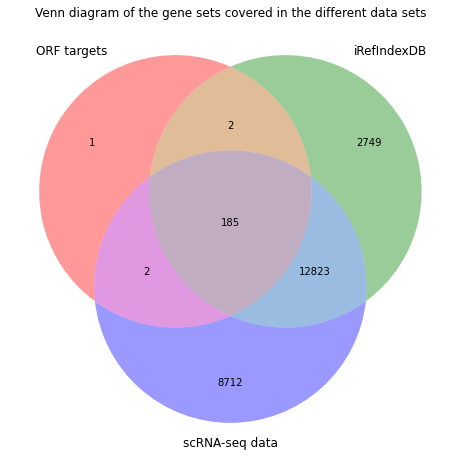

<IPython.core.display.Javascript object>

In [47]:
plt.figure(figsize=[8, 8])
venn3_unweighted(
    [
        gene_targets,
        ppi_gene_set,
        gex_gene_set,
    ],
    ["ORF targets", "iRefIndexDB", "scRNA-seq data"],
)
plt.title("Venn diagram of the gene sets covered in the different data sets")
plt.show()

We see that 13'007 genes are covered by the PPI and the scRNA-seq data set. Those include 185/190 gene targets of the ORF constructs of the study by Rohban et al. (2017). Out of the remaining 5 targets 2 are present only in the PPI or only in the scRNA-seq data set. We will quickly look at those genes and one is not present in either of the two.

The genes that are not present in the scRNAseq data set are: MEK1, MOS and PRKACG. The ones not present in the PPI are CSNK1E, IRGM and MEK1. Thus, MEK1 is the one not present in either of the two.

Going forward we will focus on the 185 target genes that are present in both the PPI and the scRNA-seq data set.

---

## 3. Exploratory analyses of the interactome

We will use the human PPI obtained from the iRefIndexDB as a basis for the derivation of the interactome of the U2OS cells spanning the 185 different targets. To get a better understanding of the PPI in particular with respect to the neighborhood of our 185 target genes, we first have a deeper look into the PPI data.

The PPI consists of 15'759 nodes defining respective proteins and 182'002 edges forming one lare connected component. The average degree of each node in the PPI is 23, i.e. that is each protein was found to interact with 23 other proteins on average.

### 3a. Node statistics

In [52]:
print(nx.info(ppi_graph.interactome_graph))

Name: 
Type: Graph
Number of nodes: 15759
Number of edges: 182002
Average degree:  23.0982


<IPython.core.display.Javascript object>

To get a better understanding of the connectivity of the graph we plot a histogram of the degree for each of the nodes in the PPI.

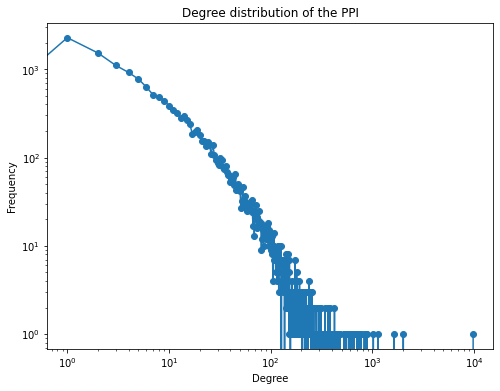

<IPython.core.display.Javascript object>

In [80]:
node_degrees = plot_degree_dist(
    ppi_graph.interactome_graph, smoothing=1, title="Degree distribution of the PPI"
)

In [88]:
print("Node degree distribution stats: ", stats.describe(node_degrees))
print(
    "25/50/75% quantiles of the node degree distribution: ",
    np.quantile(node_degrees, q=[0.25, 0.5, 0.75]),
)

Node degree distribution stats:  DescribeResult(nobs=15759, minmax=(1, 9796), mean=23.09816612729234, variance=8833.440864132572, skewness=73.3491531944346, kurtosis=7441.827114495689)
25/50/75% quantiles of the node degree distribution:  [ 3.  8. 22.]


<IPython.core.display.Javascript object>

We see that distribution of the degrees of the individual nodes of the PPI is highly variable with an average degree of $23.10 \ (\pm 93.98). The degrees range from 1 to 9796 with the lower, median and upper quartile being 1, 8 and 22 respectively.

Finally, we also look at the distribution of the eigenvector centrality in the graph. The plot below shows the respective empirical distribution of the human PPI.

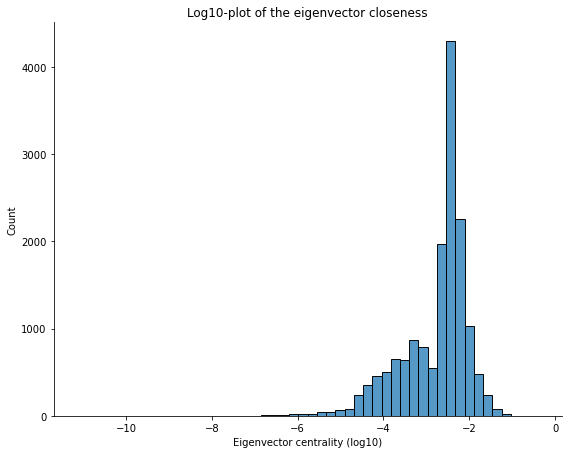

<IPython.core.display.Javascript object>

In [181]:
plot_eigenvector_centrality_dist(
    ppi_graph.interactome_graph, title="Log10-plot of the eigenvector closeness"
)

### 3b. Edge statistics

Next, we are interested in the edge distribution in the PPI. Hereby in particular the edge weight, i.e. its cost is of special interest. The histogram below shows the empirical distribution of those edge costs for our PPI.

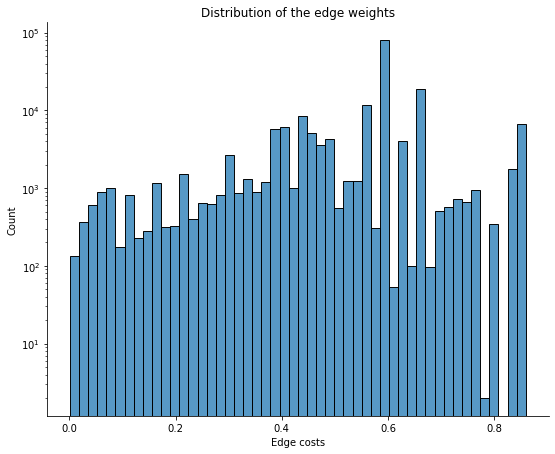

<IPython.core.display.Javascript object>

In [184]:
edge_costs = plot_edge_cost_hist(
    ppi_graph.interactome_graph, title="Distribution of the edge weights"
)

In [186]:
print("Edge cost distribution stats: ", stats.describe(edge_costs))
print(
    "25/50/75% quantiles of the edge cost distribution: ",
    np.quantile(edge_costs, q=[0.25, 0.5, 0.75]),
)

Edge cost distribution stats:  DescribeResult(nobs=182002, minmax=(0.000780299, 0.85922), mean=0.5509360403807595, variance=0.020775117085169797, skewness=-0.9879724142264047, kurtosis=2.211429655368792)
25/50/75% quantiles of the edge cost distribution:  [0.47326  0.598835 0.598835]


<IPython.core.display.Javascript object>

The edge costs take values in $[0.00,0.86)$ with an average cost of $0.5509 \ (\pm 0.1441)$. The lower, median and upper quartile are given by $0.47326$, $0.5988$ and $0.5988$ respectively.

### 3c. Target statistics

Next, we will look more closely at the 185 nodes that define the gene targets of the study of Rohban et al. (2017) and will serve as our terminals for the Prize-collecting Steiner tree-based derivation of the U2OS interactome. In particular we are interested in the connectivity of these notes, their position in the human PPI and their local neighborhoods.

Let us first look at the degrees of these nodes to assess their connectivity in the PPI.

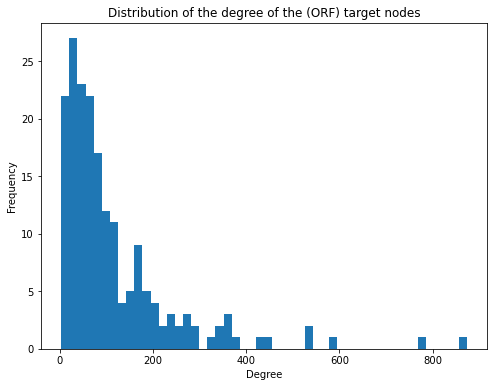

<IPython.core.display.Javascript object>

In [256]:
target_node_degrees, target_node_names = plot_degree_dist_for_nodes(
    ppi_graph.interactome_graph,
    nodes=gene_targets,
    title="Distribution of the degree of the (ORF) target nodes",
)

In [202]:
print("Target nodes' degree distribution stats: ", stats.describe(target_node_degrees))
print(
    "25/50/75% quantiles of the target nodes' degree distribution: ",
    np.quantile(target_node_degrees, q=[0.25, 0.5, 0.75]),
)

Target nodes' degree distribution stats:  DescribeResult(nobs=187, minmax=(3, 874), mean=115.11764705882354, variance=16953.65275142315, skewness=2.725383884228747, kurtosis=9.808234585088135)
25/50/75% quantiles of the target nodes' degree distribution:  [ 33.5  71.  145. ]


<IPython.core.display.Javascript object>

We see that the 187/190 targeted genes that are featured in the protein protein interaction network have an average degree of $115.12 \ (\pm 130.21)$, where their degrees take range in $(3,874)$ and the lower, middle and upper quartile are given by $33.5$, $71$ and $145$ respectively.

The ten targets with the highest node degree are shown below.

In [223]:
target_node_stats = pd.DataFrame(
    node_degrees, columns=["node_degree"], index=target_node_names
)
target_node_stats.sort_values("node_degree", ascending=False).head(10)

,node_degree
TP53,874
HSP90AA1,773
CDK2,586
BRCA1,527
TRAF6,526
SRC,448
VHL,424
IKBKE,373
CTNNB1,368
SMAD3,365


<IPython.core.display.Javascript object>

The ones with lowest degree are the following:

In [206]:
target_node_stats.sort_values("node_degree", ascending=True).head(10)

,node_degree
MAP3K9,3
CXXC4,4
VEGFC,4
PKIA,5
SMO,7
WNT5A,7
PRKACG,8
DKK1,9
SGK3,10
PSENEN,10


<IPython.core.display.Javascript object>

To assess the relative position of the target nodes in the PPI, we compute the closeness centrality for each of these nodes.

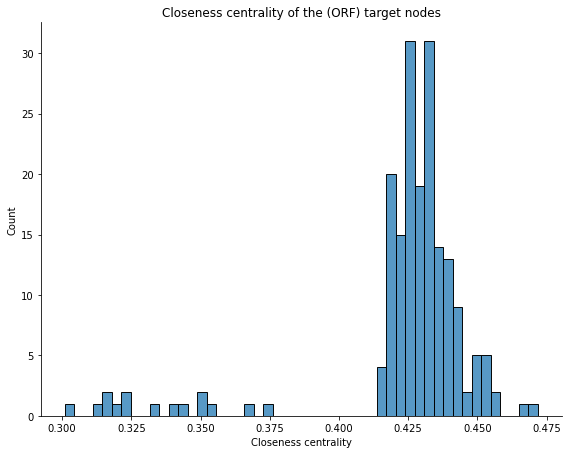

<IPython.core.display.Javascript object>

In [255]:
closeness_centrality_df = plot_closeness_centrality_dist_nodes(
    ppi_graph.interactome_graph,
    nodes=target_node_names,
    title="Closeness centrality of the (ORF) target nodes",
)

In [225]:
print(
    "Target nodes' closeness centrality distribution stats: ",
    stats.describe(np.array(closeness_centrality_df.iloc[:, 0])),
)
print(
    "25/50/75% quantiles of the target nodes' closeness centrality distribution: ",
    np.quantile(np.array(closeness_centrality_df.iloc[:, 0]), q=[0.25, 0.5, 0.75]),
)

Target nodes' closeness centrality distribution stats:  DescribeResult(nobs=187, minmax=(0.30086873508353223, 0.47185291651694816), mean=0.42359146344404935, variance=0.0008120637992734628, skewness=-2.641614818116985, kurtosis=7.080843428766931)
25/50/75% quantiles of the target nodes' closeness centrality distribution:  [0.42175985 0.42912775 0.43523774]


<IPython.core.display.Javascript object>

The closeness centrality of node $u$ describes the inverse of the average closest distance to any other node $v$ of the graph that is reachable from $u$. We see that the average closeness centrality is $0.4236 \ (\pm 0.0285)$ and it takes value in $(0.3009, 0.4719)$. That is on average the closest distance to any other node of the PPI of the 187 target genes is roughly $2.3608$, where as the minimal distance is $2.1190$ and the average distance is $3.0000$.

In [224]:
target_node_stats = target_node_stats.join(closeness_centrality_df, how="inner")

,node_degree,closeness_centrality
HSP90AA1,773,0.471853
SDHA,69,0.427486
MAPK9,96,0.430994
SRC,448,0.451066
MAPK1,278,0.443014


<IPython.core.display.Javascript object>

In [226]:
target_node_stats.sort_values("closeness_centrality", ascending=False).head(10)

,node_degree,closeness_centrality
HSP90AA1,773,0.471853
TP53,874,0.466848
CTNNB1,368,0.457403
TRAF6,526,0.456489
SMAD3,365,0.454200
BRCA1,527,0.453090
AKT1,332,0.452959
VHL,424,0.452335
CDK2,586,0.452050
SRC,448,0.451066


<IPython.core.display.Javascript object>

As expected the set of the most and least central nodes of our target genes shows a high overlap with those that showed the highest resp. lowest node degree.

To better understand the relative location of the target genes in the PPI, we are next interested in the distribution of the shortest paths from each of the target genes to any other of these target genes.

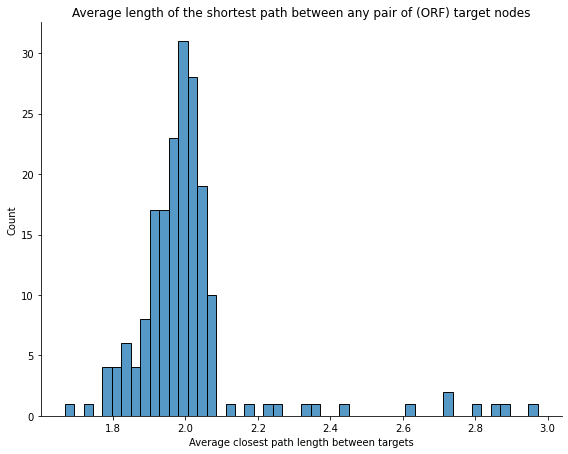

<IPython.core.display.Javascript object>

In [258]:
avg_spls_targets = plot_average_shortest_path_length_dist_nodes(
    ppi_graph.interactome_graph,
    nodes=target_node_names,
    title="Average length of the shortest path between any pair of (ORF) target nodes",
)

In [238]:
print(
    "Distribution of the average shortest path length between any two target nodes stats: ",
    stats.describe(np.array(avg_spls_targets.iloc[:, 0])),
)
print(
    "25/50/75% quantiles of the distribution of the average shortest path length between any two target nodes: ",
    np.quantile(np.array(avg_spls_targets.iloc[:, 0]), q=[0.25, 0.5, 0.75]),
)

Distribution of the average shortest path length between any two target nodes stats:  DescribeResult(nobs=187, minmax=(1.6666666666666667, 2.9731182795698925), mean=2.008970156977747, variance=0.03374829892856458, skewness=3.1325140229027264, kurtosis=11.826136309945385)
25/50/75% quantiles of the distribution of the average shortest path length between any two target nodes:  [1.9327957  1.98924731 2.03225806]


<IPython.core.display.Javascript object>

The results above show that on average two targeted genes are on average $2.0090 \ (\pm 0.1837)$ apart from each other. This will be important later on as it suggests that to connect these nodes we would expect the Steiner tree solution to consist of roughly the same number of terminal as of Steiner nodes to connect them.

Finally, we are also interested in the distribution of the costs of the edges that connect any of our target nodes (genes). This is because, for our downstream analyses of finding the interactome that describes the regulatory space of the U2OS cells with special focus on the target genes, we do not want these target genes to be leaf nodes. Thus, we will expand the set of terminals to those of the target genes and their adjacent nodes in the PPI. 

We will have to assign prizes to those such that some, yet not all of these get included in the final solution. The reason, why we do not want to include all of these nodes is due to the fact that as we have seen, they can have up to 874 neighbors. Thus, the distribution of the costs of the edges connecting the target genes with their neighbors will provide guidance for the assignment of the prizes to these neighbor nodes.

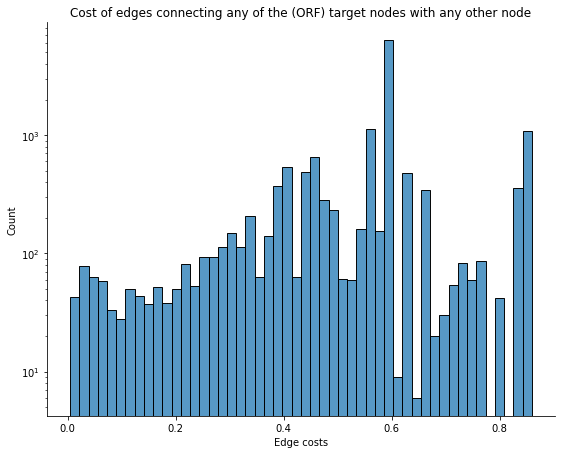

<IPython.core.display.Javascript object>

In [260]:
target_edge_costs = plot_edge_weight_dist_nodes(
    ppi_graph.interactome_graph,
    nodes=target_node_names,
    title="Cost of edges connecting any of the (ORF) target nodes with any other node",
)

In [253]:
print("Target edge cost distribution stats: ", stats.describe(target_edge_costs))
print(
    "25/50/75% quantiles of the target edge cost distribution: ",
    np.quantile(target_edge_costs, q=[0.25, 0.5, 0.75]),
)

Target edge cost distribution stats:  DescribeResult(nobs=14862, minmax=(0.0041523, 0.85922), mean=0.5549665146703002, variance=0.026193666529281397, skewness=-0.628739676935095, kurtosis=1.4095773045055742)
25/50/75% quantiles of the target edge cost distribution:  [0.45648  0.598835 0.598835]


<IPython.core.display.Javascript object>

There are 14'862 edges that connect any of the 187 target gene nodes to other nodes in the PPI. The average edge cost is slighlty higher for those compared to the average cost of all edges (0.5509 vs 0.5549).

Interestingly, the median edge cost and the upper quartile both take the same value 0.5988. Thus, one could choose a similar prize for the direct neighbors of our target nodes to ensure that roughly 25% of these will be included as their prize is greater than the edge weight connecting it to the set of target nodes (terminals).

---

## 4. Derivation of the interactome

In the following we will use the previously described data to infer an induced subtree of the human PPI that is specific for U2OS cells by solving the Prize-collecting Steiner Tree problem. Hereby, the set of terminal nodes $\mathcal{T}$ will be given by the gene targets that we would like to be part of the node set of the induced subtree. The edge weights $e_v$ are given by the costs as defined by the PPI which are seen as a negative confidence estimate of the existance of the corresponding interaction. 

The choice of the prizes is less straight-forward as the usual choice of e.g. absolute logFC in a studied process is not applicable in our scenario. This is because we do not study any progress but are interested in the generic interactome of the cell population. In this case one could use some measure of the variability of the individual genes as prizes such as the normalized dispersion as computed first by Satija et al. (2015). However, it is not given that the ones that are variable in the wildtype are also those that are important for the signal cascade leading to morphological changes upon overexpression of any of our target genes. A final fall-back solution is to assign a prize to the individual node that is chosen such that the nodes that one wants to be included in the solution are more likely to be part of the PCST solution. To this end, one could for instance uniformly assign a prize of $k$ to all terminal nodes and set the prize for all others to 0, i.e.
$$
p(v)= \mathbb{1}[v \in \mathcal{R}]
$$
for the PCST objective formally denoted by
$$
min_{{\boldsymbol{T}}=(\mathcal{V}',\mathcal{E}')} L({\boldsymbol{T}}) = \beta \sum\limits_{v' \notin \mathcal{V}'} p(v) + \sum\limits_{e'\in \mathcal{E}'} e_v
$$
is not guaranteed to include all terminals but will find a subtree of the graph.

The hyperparameter $\beta$ that trades off the node prizes against the edge costs can be tuned such that each terminal node is included in the solution to the PCST problem. In our use case this is desired as we want to ensure that the regulatory space of the cells represented by their interactome captures all the gene targets such that we have as many data points as possible to learn the mapping from the structural to the regulatory space as described in the paper.

Irrespective of the choice of the hyperparameter $\beta$ the solution to the PCST problem is guaranteed to satisfy the following condition: Suppose the prize of a node $p_v > 0$ if $v \in \mathcal{R}$ and $p_v=0$ otherwise and the edge cost $e_v > 0 \ \forall v\in\mathcal{V}$, then in the tree $\boldsymbol{T^*}$ that is an optimal solution to the PCST problem for some choice of $\beta$ it will hold that $\mathcal{L}=\{v | \textrm{degree}(v) = 1\} \subset \mathcal{R}$, where $\mathcal{L}$ is the set of leafs in the tree $\boldsymbol{T^*}$.

This is because adding a Steiner node $v' \notin \mathcal{R}$ to the tree $\boldsymbol{T^*}$ to one of the leaf terminals via edge $e_{v'}$ which yields tree $\boldsymbol{T'}$ would increase the value of the PCST objective function as $p_{v'} = 0$ and $e_{v'} > 0$ by definition and hence $L(\boldsymbol{T'}) > L(\boldsymbol{T^*})$.

However, in some situations it might be desired to ensure that none of the terminal nodes end up as leafs in the optimal solution. There has been some work on the related problem of solving the internal Steiner tree problem that was shown to be SNP hard. While there exists approximative algorithms to solve those problems that scale linearly with the complexity of the algorithms to solve the Steiner tree problem for a given node set, we propose a prize-assigning function that can be tuned to lead to the desired properties of the optimal solution when solving the PCST problem.

In particular, we propose to replace $p(v)$ in the objective by the function $p'(v)$ that is defined as
$$
p'(v) = p(v)\alpha^{-l_v},
$$
where $l_v$ is the minimal shortest path distance from node $v$ to any node $u\in\mathcal{R}$ and $\alpha$ is a tunable hyperparameter controlling the rate of the exponential decay of the prizes. Note that the prize still scales linearly with output of the raw prize-assignment function $p(v)$ that e.g. could set the prize to an absolute log fold-change value.

In our use case, we will use
$$
p(v)=\mathbb{1}[l_v \leq k],
$$
that is we assign prize 0 to all nodes with a minimal shortest path length to any of the terminal nodes $\mathcal{R}$ greater than $k$.

The intuition behind that adjusted prize assignment is the following. We aim to derive the interactome spanning all target nodes (terminals). However, we also want to capture their local neighborhoods as given the PPI which potentially describe causal regulating effects of these nodes. For that reason we would like include the parts of the local neighborhood of our terminal nodes in the PCST solution. Thereby the closer neighborhood is deemed to be more important than a more extended one as e.g. direct neighbors linked in the PPI might indicate a direct causal relationship between the respective nodes. As a consequence the prize decays exponentially with increasing distance to any of the terminals. As a consequence the optimal solution is more likely to include nodes with lower order causal relationships with the terminal nodes. Nonetheless, if there exist high-confidence edges, i.e. edges with low weight even high-order causal relationships might be reflected in the solution to the PCST problem as their exponentially decaying prize still outweights the cost for including the required edges. Lastly, the choice of $p(v)$ is motivated by the fact that may want to set an upper limit for the distance of the Steiner nodes in the solution to the PCST problem and the set of terminal nodes thus allowing us to control the maximum depth of the added neighborhoods for the terminal nodes.

### 3a. Preprocessing

Before we can run the PCST algorithm, we first need to run a number of preprocessing steps:
1. Construction of a 2D array representing the edges of the PPI
2. Construction of a 1D array representing the corresponding edge costs
3. Construction of a 1D array representing the prizes for the nodes of the PPI

Note that for the derivation of the prizes we need to set the hyperparameters $(\alpha,\beta)$. Those should be chosen based on a gridsearch to derive a robust solution that satisfies the constraints of e.g. all terminal nodes being internal nodes in the final solution.

In [527]:
alpha = 1
beta = 1.0
k = 0
terminals = gene_targets.intersection(set(ppi_graph.interactome_graph.nodes()))

<IPython.core.display.Javascript object>

In [529]:
node_id_dict = get_node_id_dict(ppi_graph.interactome_graph)
edge_array = get_edge_array(ppi_graph.interactome_graph, node_id_dict)
prize_array = get_prize_array(
    graph=ppi_graph.interactome_graph,
    terminals=terminals,
    node_id_dict=node_id_dict,
    alpha=alpha,
    beta=beta,
    k=0,
)

Compute node prizes: 100%|██████████| 15759/15759 [02:41<00:00, 97.70it/s] 


<IPython.core.display.Javascript object>

Let us quickly look at the distribution of the assigned node prizes for an example choice of $(\alpha,\beta)=(2,1)$.

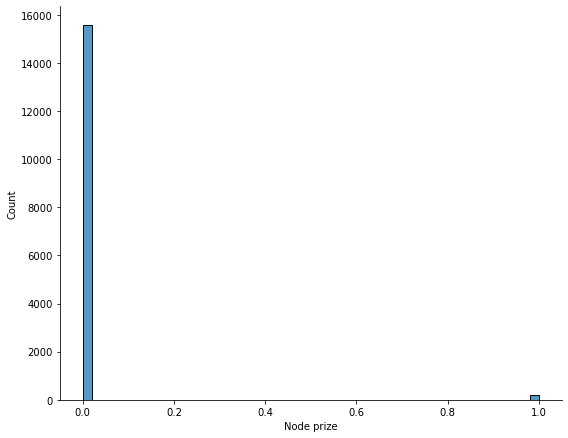

<IPython.core.display.Javascript object>

In [530]:
plot_prize_array(prize_array)

As seen above our function assigns a prize of 1 to all terminal nodes and a prize that is $2^{-l_v}$ for all other nodes. We also see that the maximum of the minimum distance of any node to one of the terminal nodes (target genes) is 4 as each node gets assigned a prize of at least $2^{-4}$.

### 3b. PCST algorithm

#### 3b.i. Running the algorithm

After setting up the required quantatities we can run of the PCST algorithm to derive the PCST. To this end, we will use the implementation by the pcst_fast package. We will run the algorithm over a grid of values for the hyperparameters $(\alpha,\beta)$ to assess the sensitivity of the solution with respect to those parameters.

In [555]:
pcst_trees_dict, pcst_augmented_trees_dict, hyperparameter_grid, graph = run_pcst_sensitivity_analyses(
    ppi_graph,
    terminals,
    alphas=[1, 1.5, 2, 5, 10, 100],
    betas=[1, 2, 5, 10, 100],
    ks=[0, 1, 2, None],
)

Compute prizes for (alpha,k)=(1,0): 100%|██████████| 15759/15759 [02:38<00:00, 99.55it/s] 
03:54:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
03:54:32 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
03:54:32 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
03:54:32 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(1,1): 100%|██████████| 15759/15759 [02:37<00:00, 100.37it/s]
03:57:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
03:57:11 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
03:57:11 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.gr

INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
04:32:01 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(5,None): 100%|██████████| 15759/15759 [02:33<00:00, 102.46it/s]
04:34:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
04:34:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
04:34:39 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
04:34:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(10,0): 100%|██████████| 15759/15759 [02:32<00:00, 103.22it/s]
04:37:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:16 - OI2:

<IPython.core.display.Javascript object>

In [556]:
with open("../../data/ppi/grid_pcs_trees_dict_072621.pkl", "wb") as handle:
    pickle.dump(trees_dict, handle)

with open("../../data/ppi/grid_pcs_augmented_trees_dict_072621.pkl", "wb") as handle:
    pickle.dump(augmented_trees_dict, handle)

<IPython.core.display.Javascript object>

#### 3b.ii. Analyzing the computed trees

In [829]:
pcst_trees_dict = pickle.load(
    open("../../data/ppi/grid_pcs_trees_dict_072621.pkl", "rb")
)
pcst_augmented_trees_dict = pickle.load(
    open("../../data/ppi/grid_pcs_trees_dict_072621.pkl", "rb")
)

<IPython.core.display.Javascript object>

In [834]:
pcst_sensitivity_analyses_results = analyze_pcst_sensitivity_analyses_results(
    pcst_trees_dict, target_nodes=terminals
)
pcst_sensitivity_analyses_results.head(20)

Analyze tree:: 100%|██████████| 120/120 [00:44<00:00,  2.70it/s]


,alpha,beta,k,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_alpha_1_beta_1_k_0,1.0,1.0,0.0,298,297,1,298,1.993289,1.666877,115,20,2,2.750000,1.971674
tree_alpha_1_beta_2_k_0,1.0,2.0,0.0,359,358,1,359,1.994429,1.602565,128,25,0,2.680000,1.737124
tree_alpha_1_beta_5_k_0,1.0,5.0,0.0,359,358,1,359,1.994429,1.602565,128,25,0,2.680000,1.737124
tree_alpha_1_beta_10_k_0,1.0,10.0,0.0,359,358,1,359,1.994429,1.602565,128,25,0,2.680000,1.737124
tree_alpha_1_beta_100_k_0,1.0,100.0,0.0,359,358,1,359,1.994429,1.602565,128,25,0,2.680000,1.737124
tree_alpha_1_beta_1_k_1,1.0,1.0,1.0,6774,6773,1,6774,1.999705,6.259000,4310,124,10,5.483871,4.320775
tree_alpha_1_beta_2_k_1,1.0,2.0,1.0,6951,6950,1,6951,1.999712,6.198788,4378,124,9,5.524194,4.330059
tree_alpha_1_beta_5_k_1,1.0,5.0,1.0,6954,6953,1,6954,1.999712,6.197567,4379,124,9,5.524194,4.330059
tree_alpha_1_beta_10_k_1,1.0,10.0,1.0,6954,6953,1,6954,1.999712,6.197567,4379,124,9,5.524194,4.330059
tree_alpha_1_beta_100_k_1,1.0,100.0,1.0,6954,6953,1,6954,1.999712,6.197567,4379,124,9,5.524194,4.330059


<IPython.core.display.Javascript object>

In [835]:
pcst_sensitivity_analyses_results.loc[
    pcst_sensitivity_analyses_results.n_target_nodes == 187
]

,alpha,beta,k,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_alpha_1_beta_1_k_None,1.0,1.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1_beta_2_k_None,1.0,2.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1_beta_5_k_None,1.0,5.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1_beta_10_k_None,1.0,10.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1_beta_100_k_None,1.0,100.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1.5_beta_2_k_None,1.5,2.0,NaN,15656,15655,1,15656,1.999872,9.875800,10802,187,30,6.149733,6.264153
tree_alpha_1.5_beta_5_k_None,1.5,5.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1.5_beta_10_k_None,1.5,10.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_1.5_beta_100_k_None,1.5,100.0,NaN,15759,15758,1,15759,1.999873,9.945304,10894,187,30,6.176471,6.301335
tree_alpha_2_beta_5_k_None,2.0,5.0,NaN,15756,15755,1,15756,1.999873,9.938667,10891,187,30,6.176471,6.301335


<IPython.core.display.Javascript object>

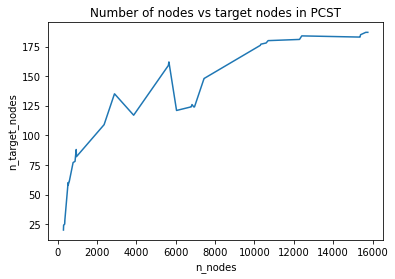

<IPython.core.display.Javascript object>

In [944]:
ax = sns.lineplot(
    data=pcst_sensitivity_analyses_results, x="n_nodes", y="n_target_nodes"
)
ax.set_title("Number of nodes vs target nodes in PCST")
plt.show()

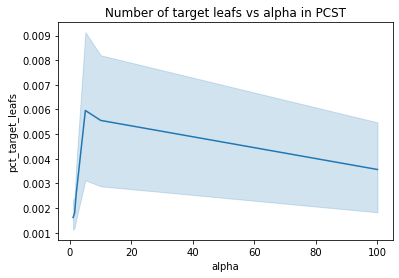

<IPython.core.display.Javascript object>

In [947]:
pcst_sensitivity_analyses_results["pct_target_leafs"] = (
    pcst_sensitivity_analyses_results.n_target_leafs
    / pcst_sensitivity_analyses_results.n_nodes
)
ax = sns.lineplot(
    data=pcst_sensitivity_analyses_results, x="alpha", y="pct_target_leafs"
)
ax.set_title("Number of target leafs vs alpha in PCST")
plt.show()

### 3c. PCSF algorithm

The above procedure computes an undirected PCST solution. Alternatively, one could solve the PCSF problem, which even for fully connected components yields different solutions as it solves for the rooted PCST where each terminal node is connected to a dummy node that is added as the root. We will run a sensitivity analyses for the PCSF as well.

#### 3c. i. Running the algorithm

In [772]:
graph_params = {
    "noise": 0.0,
    "dummy_mode": "terminals",
    "exclude_terminals": False,
    "seed": 1,
    "pruning": "strong",
    "verbosity_level": 0,
    "g": 0,
}

<IPython.core.display.Javascript object>

In [816]:
(
    pcsf_trees_dict,
    pcsf_augmented_trees_dict,
    pcsf_hyperparameter_grid,
    pcsf_graph,
) = run_pcsf_sensitivity_analyses(
    ppi_graph,
    graph_params,
    terminals,
    ws=[0.1, 0.5, 1.0, 5.0],
    alphas=[1, 1.5, 2, 5, 10, 100],
    betas=[1, 2, 5, 10, 100],
    ks=[0, 1, 2, None],
)

Compute prizes for (alpha,k)=(1,0): 100%|██████████| 15759/15759 [00:00<00:00, 3821137.52it/s]
06:58:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:04 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:04 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:04 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:05 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:05 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:05 - OI2: INFO - []

06:58:17 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:17 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:17 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:18 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:18 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:18 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:18 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:18

06:58:33 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:34 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:35 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:35 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:35 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:37

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:56 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:56 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:58:57 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:57 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:58:57 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:58:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

06:59:19 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:19 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:21 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:21 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:21 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:22 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:22 - OI2: INFO - Members of the prize file not present in 

06:59:41 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:41 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:41 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:41 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:42 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:42 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:42 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:43

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:55 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
06:59:56 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:56 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
06:59:56 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
06:59:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:00:14 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:00:14 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:00:15 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:15 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:00:15 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:00:16 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:16 - OI2: INFO - Members of the prize file not present in 

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:00:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:39 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:00:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(1.5,None): 100%|██████████| 15759/15759 [00:00<00:00, 2743112.41it/s]
07:00:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:00:40 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:40 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:00:40 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:00:41 - OI2: INFO - Duplicated gene symbols in the pri

07:01:02 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:02 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:03 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:03 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:03 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:05 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:05 - OI2: INFO - Members of the prize file not present in 

07:01:17 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:18 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:18 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:18 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:19 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:19 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:19 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:20

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:33 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:33 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:33 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:34 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:01:52 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:52 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:53 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:53 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:01:53 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:01:54 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:01:54 - OI2: INFO - Members of the prize file not present in 

07:02:13 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:14 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:15 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:15 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:16 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:16 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:16 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:17

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:36 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:36 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:36 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:37 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:37 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:37 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:02:50 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:50 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:51 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:51 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:02:51 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:02:51 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:02:51 - OI2: INFO - Members of the prize file not present in 

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:06 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:06 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:06 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:07 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:07 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:07 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(5,2): 100%|██████████| 15759/15759 [00:00<00:00, 2737658.91it/s]
07:03:08 - OI2: INFO - Duplicated gene symbols in the prize fi

07:03:22 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:22 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:23 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:23 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:23 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:24 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:24 - OI2: INFO - Members of the prize file not present in 

07:03:38 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:39 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:40 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:40 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:40 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:41

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:53 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:53 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:53 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:03:54 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:54 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:03:54 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:03:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:04:08 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:08 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:09 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:09 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:09 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:10 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:10 - OI2: INFO - Members of the prize file not present in 

07:04:23 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:23 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:23 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:23 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:24 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:24 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:24 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:25

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:39 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:39 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:39 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:04:54 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
Compute prizes for (alpha,k)=(100,0): 100%|██████████| 15759/15759 [00:00<00:00, 3951813.75it/s]
07:04:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:55 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:04:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:04:55 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:04:55 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:07 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:07 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:07 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:08 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:08 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:08 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

07:05:20 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:20 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:21 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:21 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:21 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:22 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:22 - OI2: INFO - Members of the prize file not present in 

07:05:33 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:34 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:34 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:35 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:35 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:35 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:36

INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:47 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:47 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:47 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize file (we'll keep the max prize):
07:05:48 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:48 - OI2: INFO - Members of the prize file not present in the interactome:
INFO:OmicsIntegrator.graph:Members of the prize file not present in the interactome:
07:05:48 - OI2: INFO - []
INFO:OmicsIntegrator.graph:[]
07:05:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
INFO:OmicsIntegrator.graph:Duplicated gene symbols in the prize 

<IPython.core.display.Javascript object>

In [817]:
with open("../../data/ppi/grid_pcsf_trees_dict_072621.pkl", "wb") as handle:
    pickle.dump(pcsf_trees_dict, handle)

with open("../../data/ppi/grid_pcsf_augmented_trees_dict_072621.pkl", "wb") as handle:
    pickle.dump(pcsf_augmented_trees_dict, handle)

<IPython.core.display.Javascript object>

#### 3c. ii. Analyzing the forests

In [828]:
pcsf_trees_dict = pickle.load(
    open("../../data/ppi/grid_pcsf_trees_dict_072621.pkl", "rb")
)
pcsf_augmented_trees_dict = pickle.load(
    open("../../data/ppi/grid_pcsf_trees_dict_072621.pkl", "rb")
)

<IPython.core.display.Javascript object>

In [822]:
pcsf_sensitivity_analyses_results = analyze_pcsf_sensitivity_analyses_results(
    pcsf_trees_dict, target_nodes=terminals
)
pcsf_sensitivity_analyses_results.head(20)

Analyze tree:: 100%|██████████| 480/480 [01:15<00:00,  6.32it/s]


,alpha,beta,k,w,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_alpha_1_beta_1_k_0_w_0.1,1.0,1.0,0.0,0.1,48,47,1,48,1.958333,4.420399,34,7,2,2.00,0.925820
tree_alpha_1_beta_2_k_0_w_0.1,1.0,2.0,0.0,0.1,48,47,1,48,1.958333,4.420399,34,7,2,2.00,0.925820
tree_alpha_1_beta_5_k_0_w_0.1,1.0,5.0,0.0,0.1,48,47,1,48,1.958333,4.420399,34,7,2,2.00,0.925820
tree_alpha_1_beta_10_k_0_w_0.1,1.0,10.0,0.0,0.1,48,47,1,48,1.958333,4.420399,34,7,2,2.00,0.925820
tree_alpha_1_beta_100_k_0_w_0.1,1.0,100.0,0.0,0.1,48,47,1,48,1.958333,4.420399,34,7,2,2.00,0.925820
tree_alpha_1_beta_1_k_0_w_0.5,1.0,1.0,0.0,0.5,297,296,1,297,1.993266,7.161905,169,25,3,2.52,1.857310
tree_alpha_1_beta_2_k_0_w_0.5,1.0,2.0,0.0,0.5,297,296,1,297,1.993266,7.161905,169,25,3,2.52,1.857310
tree_alpha_1_beta_5_k_0_w_0.5,1.0,5.0,0.0,0.5,297,296,1,297,1.993266,7.161905,169,25,3,2.52,1.857310
tree_alpha_1_beta_10_k_0_w_0.5,1.0,10.0,0.0,0.5,297,296,1,297,1.993266,7.161905,169,25,3,2.52,1.857310
tree_alpha_1_beta_100_k_0_w_0.5,1.0,100.0,0.0,0.5,297,296,1,297,1.993266,7.161905,169,25,3,2.52,1.857310


<IPython.core.display.Javascript object>

In [827]:
pcsf_sensitivity_analyses_results.loc[
    pcsf_sensitivity_analyses_results.n_target_nodes == 187
]

,alpha,beta,k,w,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_alpha_1_beta_1_k_None_w_0.5,1.0,1.0,NaN,0.5,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_2_k_None_w_0.5,1.0,2.0,NaN,0.5,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_5_k_None_w_0.5,1.0,5.0,NaN,0.5,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_10_k_None_w_0.5,1.0,10.0,NaN,0.5,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_100_k_None_w_0.5,1.0,100.0,NaN,0.5,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_1_k_None_w_1.0,1.0,1.0,NaN,1.0,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_2_k_None_w_1.0,1.0,2.0,NaN,1.0,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_5_k_None_w_1.0,1.0,5.0,NaN,1.0,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_10_k_None_w_1.0,1.0,10.0,NaN,1.0,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831
tree_alpha_1_beta_100_k_None_w_1.0,1.0,100.0,NaN,1.0,15759,15758,1,15759,1.999873,45.922251,12002,187,50,5.128342,6.297831


<IPython.core.display.Javascript object>

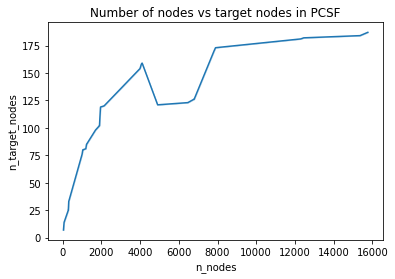

<IPython.core.display.Javascript object>

In [939]:
ax = sns.lineplot(
    data=pcsf_sensitivity_analyses_results, x="n_nodes", y="n_target_nodes"
)
ax.set_title("Number of nodes vs target nodes in PCSF")
plt.show()

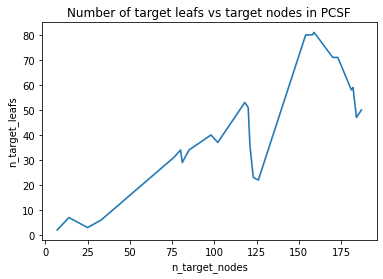

<IPython.core.display.Javascript object>

In [942]:
ax = sns.lineplot(
    data=pcsf_sensitivity_analyses_results, x="n_target_nodes", y="n_target_leafs"
)
ax.set_title("Number of target leafs vs target nodes in PCSF")
plt.show()

### 3d. ST algorithm

In contrast to the PCST does the ST algorithm ensures that all terminal nodes are part of the derived network. Thus, it has been argued that the ST solution might be prefered for inferring a subgraph from an interactome especially if the definition of the prizes is not straight-forward.

We will run the ST algorithm on the data as well that computes the minimum spanning tree of the terminal nodes from an undirected graph. Note that, in the derived tree all leafs will be given by terminal nodes. To avoid that we propose multiple extension approaches that take the computed Steiner tree and add local neighborhoods to the terminal leaf nodes. In the following we will further explain on these methods.

#### 3d.ii. Running the algorithm

In [757]:
steiner_tree, augmented_steiner_tree = run_st_analyses(
    graph.interactome_graph, terminals
)

<IPython.core.display.Javascript object>

In [949]:
oi.graph.output_networkx_graph_as_interactive_html(
    steiner_tree, filename="steiner_tree.html"
)

PosixPath('/home/paysan_d/PycharmProjects/image2reg/notebooks/ppi/steiner_tree.html')

<IPython.core.display.Javascript object>

In [951]:
oi.graph.output_networkx_graph_as_graphml_for_cytoscape(
    steiner_tree, filename="steiner_tree.graphml"
)

PosixPath('/home/paysan_d/PycharmProjects/image2reg/notebooks/ppi/steiner_tree.graphml')

<IPython.core.display.Javascript object>

In [770]:
steiner_tree_results = {
    "steiner_tree": nx.Graph(steiner_tree.edges()),
    "augmented_steiner_tree": nx.Graph(augmented_steiner_tree.edges()),
}

<IPython.core.display.Javascript object>

In [771]:
with open("../../data/ppi/steiner_tree_results_072621.pkl", "wb") as handle:
    pickle.dump(steiner_tree_results, handle)

<IPython.core.display.Javascript object>

#### 3d. ii. Expand the ST solution

In [ ]:
st_trees_dict = pickle.load(open("../../data/ppi/steiner_tree_results_072621.pkl", "rb"))
steiner_tree = st_trees_dict["steiner_tree"]

In [955]:
oi.graph.output_networkx_graph_as_interactive_html(st_trees_dict["tree_expansion_knn_alpha_None_k_2"], filename="2nn_steiner_tree.html")

PosixPath('/home/paysan_d/PycharmProjects/image2reg/notebooks/ppi/2nn_steiner_tree.html')

<IPython.core.display.Javascript object>

In [953]:
st_trees_dict, augmented_st_tree_dict = run_st_sensitivity_analyses(
    ppi_graph.interactome_graph,
    steiner_tree=steiner_tree,
    terminals=terminals,
    expansion_modes=["knn"],
    alphas=[None],
    ks=[0, 1, 2, 3, 4, 5],
)

Name: 
Type: Graph
Number of nodes: 216
Number of edges: 215
Average degree:   1.9907
Name: 
Type: Graph
Number of nodes: 275
Number of edges: 307
Average degree:   2.2327
Name: 
Type: Graph
Number of nodes: 338
Number of edges: 431
Average degree:   2.5503
Name: 
Type: Graph
Number of nodes: 413
Number of edges: 557
Average degree:   2.6973
Name: 
Type: Graph
Number of nodes: 479
Number of edges: 681
Average degree:   2.8434
Name: 
Type: Graph
Number of nodes: 541
Number of edges: 802
Average degree:   2.9649


<IPython.core.display.Javascript object>

#### 3d.iii. Analyzing the trees

In [ ]:
st_trees_dict = pickle.load(open("../../data/ppi/steiner_tree_results_072621.pkl", "rb"))
#st_augmented_trees_dict = pickle.load(open("../../data/ppi/grid_st_trees_dict_072621.pkl", "rb"))

In [929]:
st_sensitivity_analyses_results = analyze_st_sensitivity_analyses_results(
    st_trees_dict, target_nodes=terminals
)
st_sensitivity_analyses_results.head(20)

Analyze tree:: 100%|██████████| 6/6 [00:00<00:00, 10.14it/s]


,expansion,alpha,k,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_expansion_knn_alpha_None_k_0,knn,NaN,0,216,215,1,216,1.990741,5.607527,130,187,130,1.513369,0.915454
tree_expansion_knn_alpha_None_k_1,knn,NaN,1,275,307,1,275,2.232727,5.212958,91,187,36,2.090909,0.875863
tree_expansion_knn_alpha_None_k_2,knn,NaN,2,338,431,1,338,2.550296,5.404262,111,187,0,2.914439,0.977367
tree_expansion_knn_alpha_None_k_3,knn,NaN,3,413,557,1,413,2.697337,5.466864,178,187,0,3.748663,1.062706
tree_expansion_knn_alpha_None_k_4,knn,NaN,4,479,681,1,479,2.843424,5.685798,237,187,0,4.550802,1.179748
tree_expansion_knn_alpha_None_k_5,knn,NaN,5,541,802,1,541,2.964880,5.587207,278,187,0,5.304813,1.424810


<IPython.core.display.Javascript object>

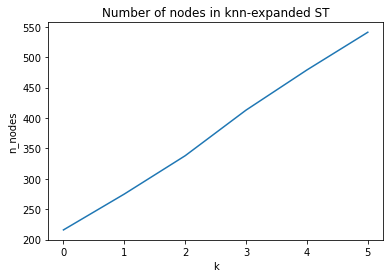

<IPython.core.display.Javascript object>

In [930]:
ax = sns.lineplot(data=st_sensitivity_analyses_results, x="k", y="n_nodes")
ax.set_title("Number of nodes in knn-expanded ST")
plt.show()

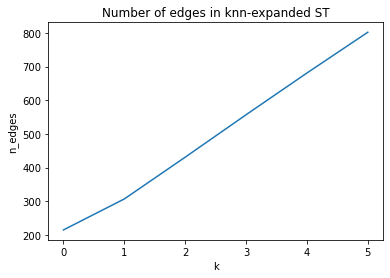

<IPython.core.display.Javascript object>

In [931]:
ax = sns.lineplot(data=st_sensitivity_analyses_results, x="k", y="n_edges")
ax.set_title("Number of edges in knn-expanded ST")
plt.show()

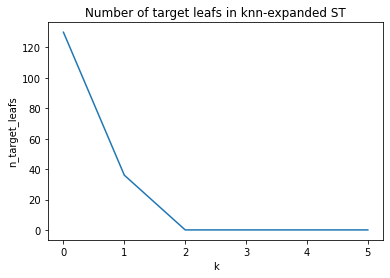

<IPython.core.display.Javascript object>

In [933]:
ax = sns.lineplot(data=st_sensitivity_analyses_results, x="k", y="n_target_leafs")
ax.set_title("Number of target leafs in knn-expanded ST")
plt.show()

In [932]:
ast_sensitivity_analyses_results = analyze_st_sensitivity_analyses_results(
    augmented_st_tree_dict, target_nodes=terminals
)
ast_sensitivity_analyses_results.head(20)

Analyze tree:: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


,expansion,alpha,k,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_target_leafs,avg_target_degree,std_target_degree
tree_expansion_knn_alpha_None_k_0,knn,NaN,0,216,2064,1,216,19.111111,18.755411,3,187,3,17.187166,13.469802
tree_expansion_knn_alpha_None_k_1,knn,NaN,1,275,2951,1,275,21.461818,21.571391,1,187,1,20.524064,15.960620
tree_expansion_knn_alpha_None_k_2,knn,NaN,2,338,3931,1,338,23.260355,23.980952,3,187,0,23.663102,18.166458
tree_expansion_knn_alpha_None_k_3,knn,NaN,3,413,5059,1,413,24.498789,26.349267,2,187,0,26.663102,20.088278
tree_expansion_knn_alpha_None_k_4,knn,NaN,4,479,6113,1,479,25.524008,28.345449,5,187,0,29.267380,22.030682
tree_expansion_knn_alpha_None_k_5,knn,NaN,5,541,7243,1,541,26.776340,30.248262,5,187,0,31.823529,24.090868


<IPython.core.display.Javascript object>

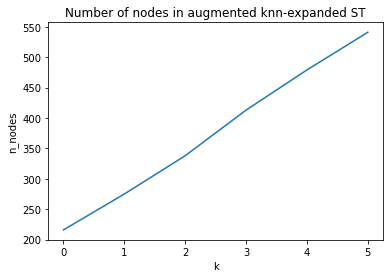

<IPython.core.display.Javascript object>

In [936]:
ax = sns.lineplot(data=ast_sensitivity_analyses_results, x="k", y="n_nodes")
ax.set_title("Number of nodes in augmented knn-expanded ST")
plt.show()

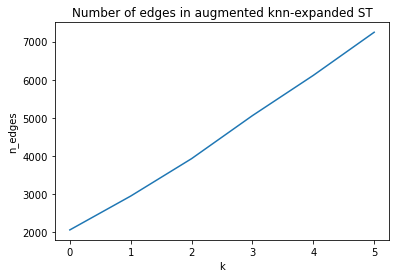

<IPython.core.display.Javascript object>

In [937]:
ax = sns.lineplot(data=ast_sensitivity_analyses_results, x="k", y="n_edges")
ax.set_title("Number of edges in augmented knn-expanded ST")
plt.show()

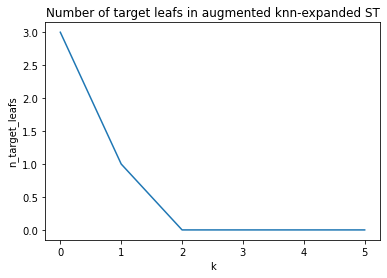

<IPython.core.display.Javascript object>

In [938]:
ax = sns.lineplot(data=ast_sensitivity_analyses_results, x="k", y="n_target_leafs")
ax.set_title("Number of target leafs in augmented knn-expanded ST")
plt.show()